# Import

In [121]:
# Notwendige Importe
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd 
# Verbindung zur PostgreSQL-Datenbank herstellen
db_user = 'postgres'
db_password = 'neues_passwort'
db_host = 'localhost'
db_port = '5432'
db_name = 'postgres'

# Engine erstellen
engine = sql.create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Funktion zum Laden eines DataFrames aus der PostgreSQL-Datenbank
def load_table(table_name, engine):
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, engine)
    return df

# Laden der notwendigen Tabellen
stadt_typen_df = load_table('dim_stadt_typen', engine)
erwerbsstatus_df = load_table('dim_erwerbsstatus', engine)
gemeinde_df = load_table('dim_gemeinde', engine)
gemeindeverband_df = load_table('dim_gemeindeverband', engine)
kreis_df = load_table('dim_stadtkreiskreisfreiestadtlandkreis', engine)
regierungsbezirk_df = load_table('dim_regierungsbezirk', engine)
land_df = load_table('dim_land', engine)
schulabschluss_df = load_table('dim_hoechster_schulabschluss', engine)



# Arbeitslosigkeit

In [122]:
# Merge der Tabellen zur Erstellung eines vollständigen Datensatzes mit Erwerbstätigkeit und zugehörigen Städten
merged_df = erwerbsstatus_df.merge(gemeinde_df, left_on='schluessel', right_on='gemeindeschluessel', how='left', suffixes=('', '_drop'))
merged_df = merged_df.merge(stadt_typen_df, left_on='schluessel', right_on='schluessel', how='left', suffixes=('', '_drop'))
merged_df = merged_df.merge(gemeindeverband_df, left_on='gemeindeverbandsschluessel', right_on='gemeindeverbandsschluessel', how='left', suffixes=('', '_drop'))
merged_df = merged_df.merge(kreis_df, left_on='kreisschluessel', right_on='kreisschluessel', how='left', suffixes=('', '_drop'))
merged_df = merged_df.merge(regierungsbezirk_df, left_on='regbezirkschluessel', right_on='regbezirkschluessel', how='left', suffixes=('', '_drop'))
merged_df = merged_df.merge(land_df, left_on='landesschluessel', right_on='landesschluessel', how='left', suffixes=('', '_drop'))

# Entfernen der redundanten Spalten
cols_to_drop = [col for col in merged_df.columns if '_drop' in col]
merged_df.drop(columns=cols_to_drop, inplace=True)

# check
# Ergebnis anzeigen
merged_df.head()

,schluessel,erwerbstat_kurz_stp,erwerbstat_kurz_stp__m,erwerbstat_kurz_stp__w,erwerbstat_kurz_stp__1,erwerbstat_kurz_stp__1_m,erwerbstat_kurz_stp__1_w,erwerbstat_kurz_stp__11,erwerbstat_kurz_stp__11_m,erwerbstat_kurz_stp__11_w,...,erwerbstat_kurz_stp__2,erwerbstat_kurz_stp__2_m,erwerbstat_kurz_stp__2_w,gemeindeschluessel,name,gemeindeverbandsschluessel,kreisschluessel,regbezirkschluessel,landesschluessel,typ
0,00,80790220,39756700,41033520,43758350,23001730,20756620,41047770,21622700,19425070,...,37031860,16754970,20276900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2864310,1401220,1463090,1585940,824160,761780,1479510,773840,705670,...,1278370,577060,701310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01001,92070,45470,46600,52900,28410,24490,48070,26040,22030,...,39170,17060,22110,NaN,NaN,NaN,NaN,NaN,NaN,Stadt
3,010010000000,92070,45470,46600,52900,28410,24490,48070,26040,22030,...,39170,17060,22110,010010000000,Flensburg,010010000,01001,010,01,Stadt
4,01002,243430,119360,124070,139920,72500,67420,128800,67060,61740,...,103510,46860,56650,NaN,NaN,NaN,NaN,NaN,NaN,Landeshauptstadt


   landesschluessel  erwerbstätige  arbeitslose  arbeitslosenquote  \
0                01        1649600        65980           3.845930   
1                02        1737860        73870           4.077318   
2                03        5875630       184660           3.047049   
3                04         676590        33180           4.674754   
4                05       17140660       622330           3.503521   
5                06        4733370       166030           3.388782   
6                07        1696710        61520           3.498973   
7                08        7546060       236080           3.033613   
8                09        7122400       264850           3.585231   
9                10         898090        29250           3.154183   
10               11        3484430       148750           4.094209   
11               12        1673170        49320           2.863297   
12               13         688610        24670           3.458670   
13               14 

C:\Users\hp\AppData\Local\Temp\ipykernel_29660\3213660904.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='arbeitslosenquote', y='name', data=bundesland_data, palette='viridis')


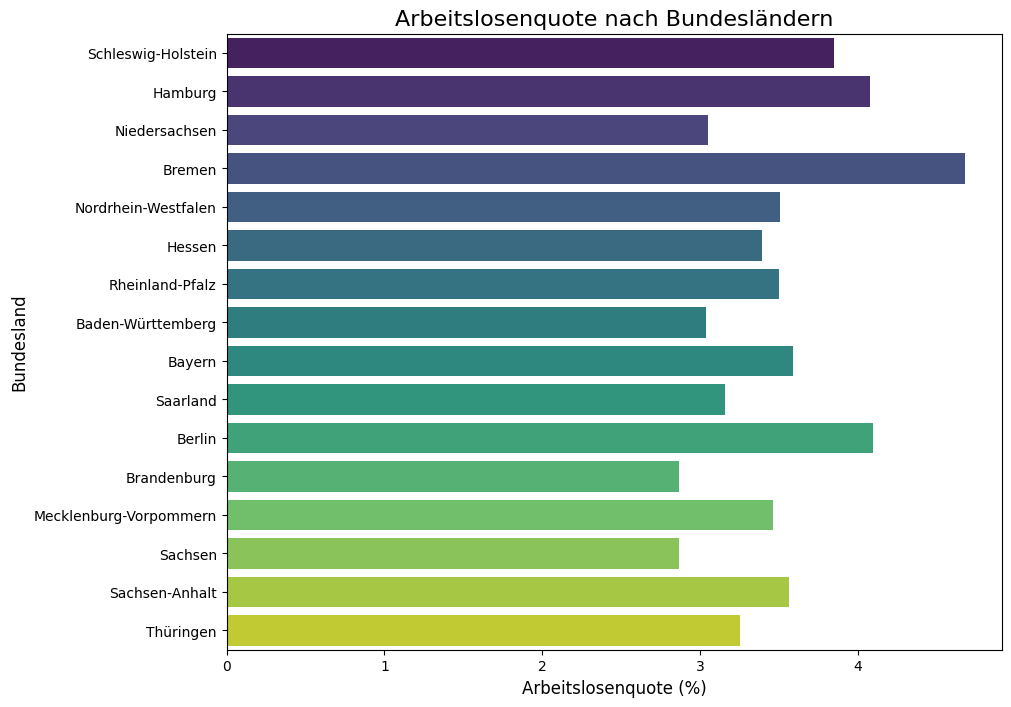

In [123]:
# Laden der notwendigen Tabellen
faktentabelle_df = load_table('faktentabelle', engine)
land_df = load_table('dim_land', engine)

# Aggregieren der Daten nach Bundesland
bundesland_data = faktentabelle_df.groupby('landesschluessel').agg(
    erwerbstätige=('erwerbstätige', 'sum'),
    arbeitslose=('arbeitslose', 'sum')
).reset_index()

# Berechnen der Arbeitslosenquote (in Prozent)
bundesland_data['arbeitslosenquote'] = (bundesland_data['arbeitslose'] / (bundesland_data['erwerbstätige'] + bundesland_data['arbeitslose'])) * 100

# Merge mit dem Bundeslandnamen
bundesland_data = bundesland_data.merge(land_df, on='landesschluessel')

# Anzeige der aggregierten Daten
print(bundesland_data)

# Plot erstellen
plt.figure(figsize=(10, 8))
sns.barplot(x='arbeitslosenquote', y='name', data=bundesland_data, palette='viridis')

# Titel und Labels hinzufügen
plt.title('Arbeitslosenquote nach Bundesländern', fontsize=16)
plt.xlabel('Arbeitslosenquote (%)', fontsize=12)
plt.ylabel('Bundesland', fontsize=12)

# Plot anzeigen
plt.show()

   gemeindeschluessel  erwerbstätige  arbeitslose  arbeitslosenquote  \
0        020000000000        1737860        73870           4.077318   
1        032410001001         500790        21420           4.101798   
2        040110000000         560630        26340           4.487453   
3        051110000000         598950        25940           4.151131   
4        051120000000         492790        26240           5.055584   
5        051130000000         559380        24020           4.117244   
6        051240000000         350430        17280           4.699355   
7        053140000000         314930        13200           4.022796   
8        053150000000         997330        40120           3.867174   
9        057110000000         324300        12540           3.722836   
10       059110000000         348020        14260           3.936182   
11       059130000000         588400        28980           4.694030   
12       064120000000         732240        32660           4.26

C:\Users\hp\AppData\Local\Temp\ipykernel_29660\3153317974.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='arbeitslosenquote', y='name', data=stadt_aggregiert, palette='viridis')


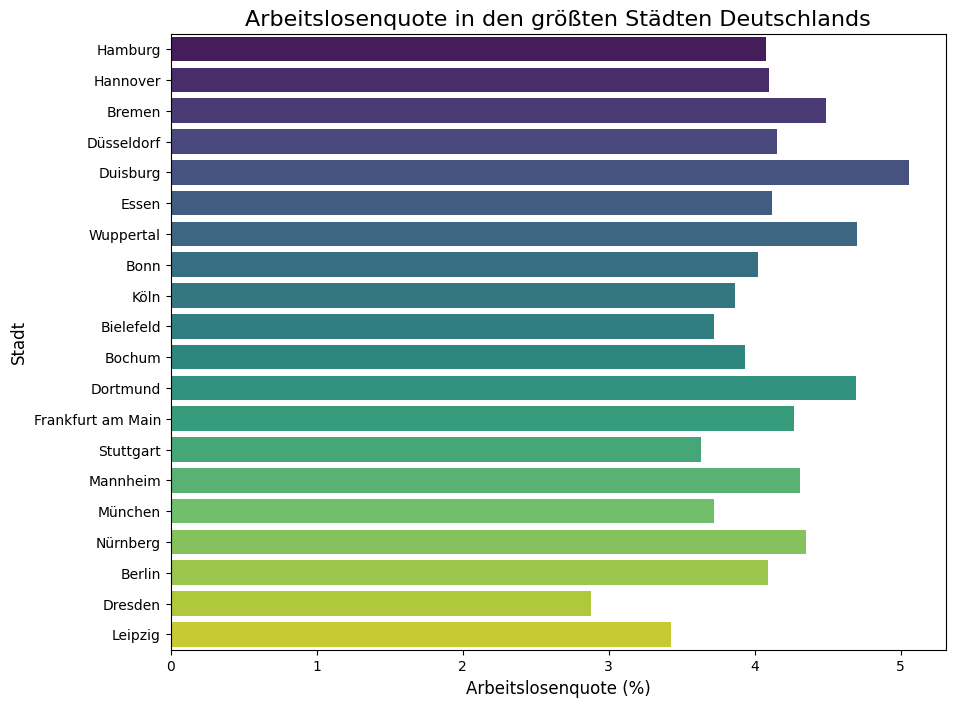

In [124]:
# Liste der sechs größten Städte Deutschlands (nach Einwohnerzahl)
grosse_stadte = [
    'Berlin', 
    'Hamburg', 
    'München', 
    'Köln', 
    'Frankfurt am Main', 
    'Stuttgart', 
    'Düsseldorf', 
    'Leipzig', 
    'Dortmund', 
    'Essen', 
    'Bremen', 
    'Dresden', 
    'Hannover', 
    'Nürnberg', 
    'Duisburg', 
    'Bochum', 
    'Wuppertal', 
    'Bielefeld', 
    'Bonn', 
    'Mannheim'
]


# Laden der notwendigen Tabellen
faktentabelle_df = load_table('faktentabelle', engine)
stadt_df = load_table('dim_gemeinde', engine)

# Filtern der Daten nach den größten Städten
stadt_data = stadt_df[stadt_df['name'].isin(grosse_stadte)]

# Aggregieren der Daten nach Stadt
stadt_aggregiert = faktentabelle_df[faktentabelle_df['gemeindeschluessel'].isin(stadt_data['gemeindeschluessel'])].groupby('gemeindeschluessel').agg(
    erwerbstätige=('erwerbstätige', 'sum'),
    arbeitslose=('arbeitslose', 'sum')
).reset_index()

# Berechnen der Arbeitslosenquote (in Prozent)
stadt_aggregiert['arbeitslosenquote'] = (stadt_aggregiert['arbeitslose'] / (stadt_aggregiert['erwerbstätige'] + stadt_aggregiert['arbeitslose'])) * 100

# Merge mit den Stadtnamen
stadt_aggregiert = stadt_aggregiert.merge(stadt_df[['gemeindeschluessel', 'name']], on='gemeindeschluessel')

# Anzeige der aggregierten Daten
print(stadt_aggregiert)

# Plot erstellen
plt.figure(figsize=(10, 8))
sns.barplot(x='arbeitslosenquote', y='name', data=stadt_aggregiert, palette='viridis')

# Titel und Labels hinzufügen
plt.title('Arbeitslosenquote in den größten Städten Deutschlands', fontsize=16)
plt.xlabel('Arbeitslosenquote (%)', fontsize=12)
plt.ylabel('Stadt', fontsize=12)

# Plot anzeigen
plt.show()

In [125]:
# Merge der Tabellen zur Erstellung eines vollständigen Datensatzes mit Erwerbstätigkeit und zugehörigen Städten
schule_df = schulabschluss_df.merge(gemeinde_df, left_on='schluessel', right_on='gemeindeschluessel', how='left', suffixes=('', '_drop'))
schule_df = schule_df.merge(stadt_typen_df, left_on='schluessel', right_on='schluessel', how='left', suffixes=('', '_drop'))
schule_df = schule_df.merge(gemeindeverband_df, left_on='gemeindeverbandsschluessel', right_on='gemeindeverbandsschluessel', how='left', suffixes=('', '_drop'))
schule_df = schule_df.merge(kreis_df, left_on='kreisschluessel', right_on='kreisschluessel', how='left', suffixes=('', '_drop'))
schule_df = schule_df.merge(regierungsbezirk_df, left_on='regbezirkschluessel', right_on='regbezirkschluessel', how='left', suffixes=('', '_drop'))
schule_df = schule_df.merge(land_df, left_on='landesschluessel', right_on='landesschluessel', how='left', suffixes=('', '_drop'))

# Entfernen der redundanten Spalten
cols_to_drop = [col for col in schule_df.columns if '_drop' in col]
schule_df.drop(columns=cols_to_drop, inplace=True)


In [126]:
schule_df.head()

,schluessel,schulabs_stp,schulabs_stp__m,schulabs_stp__w,schulabs_stp__1,schulabs_stp__1_m,schulabs_stp__1_w,schulabs_stp__2,schulabs_stp__2_m,schulabs_stp__2_w,...,schulabs_stp__3,schulabs_stp__3_m,schulabs_stp__3_w,gemeindeschluessel,name,gemeindeverbandsschluessel,kreisschluessel,regbezirkschluessel,landesschluessel,typ
0,00,69451580,33941830,35509750,2813430,1422440,1391000,61869570,30110910,31758660,...,4768580,2408490,2360090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2473130,1200580,1272550,103590,52550,51040,2252550,1087850,1164710,...,116990,60190,56810,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01001,80000,39400,40600,3590,1750,1830,71000,34810,36190,...,5410,2830,2580,NaN,NaN,NaN,NaN,NaN,NaN,Stadt
3,010010000000,80000,39400,40600,3590,1750,1830,71000,34810,36190,...,5410,2830,2580,010010000000,Flensburg,010010000,01001,010,01,Stadt
4,01002,212690,103790,108900,8570,4480,4090,190440,92530,97910,...,13680,6780,6900,NaN,NaN,NaN,NaN,NaN,NaN,Landeshauptstadt


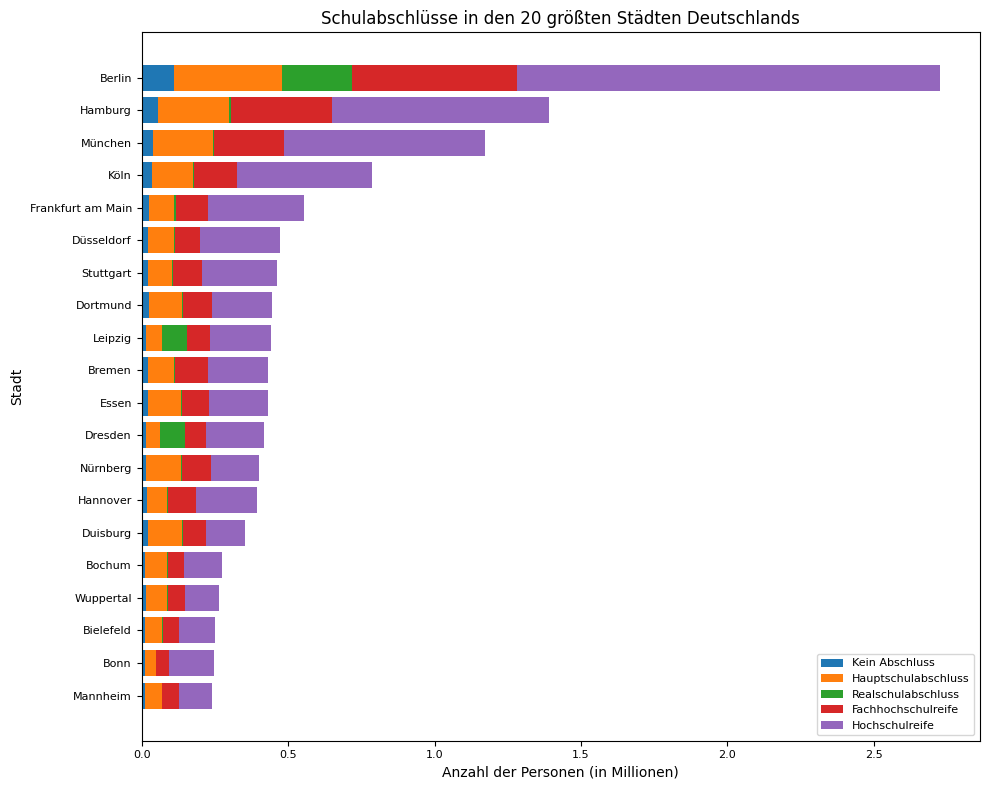

In [127]:
# Liste der 20 größten Städte Deutschlands
grosse_stadte = [
    'Berlin', 'Hamburg', 'München', 'Köln', 'Frankfurt am Main', 'Stuttgart', 
    'Düsseldorf', 'Leipzig', 'Dortmund', 'Essen', 'Bremen', 'Dresden', 
    'Hannover', 'Nürnberg', 'Duisburg', 'Bochum', 'Wuppertal', 
    'Bielefeld', 'Bonn', 'Mannheim'
]

# Filtern der Daten für die 20 größten Städte
groesste_staedte_df = schule_df[schule_df['name'].isin(grosse_stadte)].dropna(subset=['name'])

# Daten für das gestapelte Balkendiagramm vorbereiten (Werte in Millionen umrechnen)
groesste_staedte_df['gesamt'] = groesste_staedte_df[
    ['schulabs_stp__1', 'schulabs_stp__21', 'schulabs_stp__22', 'schulabs_stp__23', 'schulabs_stp__24']
].sum(axis=1) / 1e6

# Sortieren nach der Gesamtzahl der Schulabschlüsse in absteigender Reihenfolge
groesste_staedte_df = groesste_staedte_df.sort_values(by='gesamt', ascending=True)

staedte = groesste_staedte_df['name']
kein_abschluss = groesste_staedte_df['schulabs_stp__1'] / 1e6
hauptschulabschluss = groesste_staedte_df['schulabs_stp__21'] / 1e6
realschulabschluss = groesste_staedte_df['schulabs_stp__22'] / 1e6
fachhochschulreife = groesste_staedte_df['schulabs_stp__23'] / 1e6
hochschulreife = groesste_staedte_df['schulabs_stp__24'] / 1e6

# Erstellen des gestapelten Balkendiagramms mit Städten auf der y-Achse in absteigender Reihenfolge
plt.figure(figsize=(10, 8))

plt.barh(staedte, kein_abschluss, label='Kein Abschluss')
plt.barh(staedte, hauptschulabschluss, left=kein_abschluss, label='Hauptschulabschluss')
plt.barh(staedte, realschulabschluss, left=kein_abschluss + hauptschulabschluss, label='Realschulabschluss')
plt.barh(staedte, fachhochschulreife, left=kein_abschluss + hauptschulabschluss + realschulabschluss, label='Fachhochschulreife')
plt.barh(staedte, hochschulreife, left=kein_abschluss + hauptschulabschluss + realschulabschluss + fachhochschulreife, label='Hochschulreife')

# Diagrammeinstellungen mit angepasster Schriftgröße
plt.xlabel('Anzahl der Personen (in Millionen)', fontsize=10)
plt.ylabel('Stadt', fontsize=10)
plt.title('Schulabschlüsse in den 20 größten Städten Deutschlands', fontsize=12)
plt.legend(loc='lower right', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


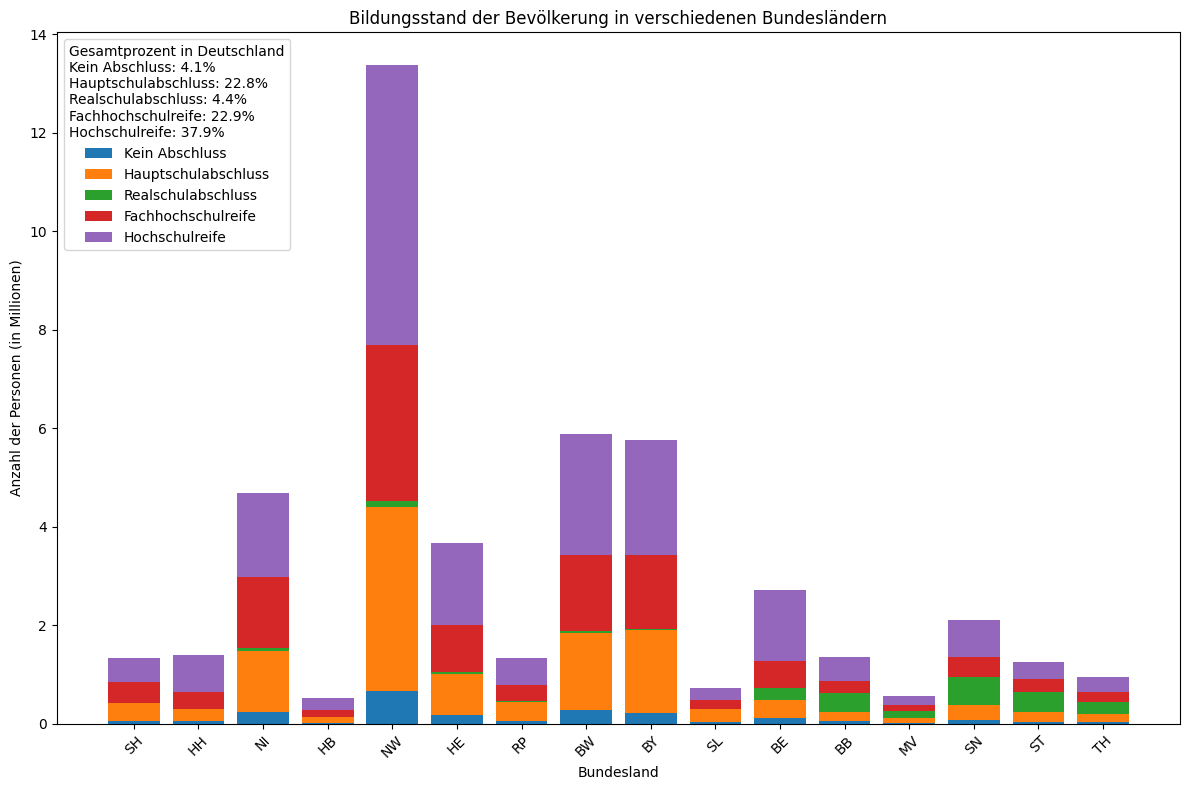

In [128]:

# Mapping von Landesschlüssel zu Bundesland-Kürzel
land_kuerzel = {
    '01': 'SH',  # Schleswig-Holstein
    '02': 'HH',  # Hamburg
    '03': 'NI',  # Niedersachsen
    '04': 'HB',  # Bremen
    '05': 'NW',  # Nordrhein-Westfalen
    '06': 'HE',  # Hessen
    '07': 'RP',  # Rheinland-Pfalz
    '08': 'BW',  # Baden-Württemberg
    '09': 'BY',  # Bayern
    '10': 'SL',  # Saarland
    '11': 'BE',  # Berlin
    '12': 'BB',  # Brandenburg
    '13': 'MV',  # Mecklenburg-Vorpommern
    '14': 'SN',  # Sachsen
    '15': 'ST',  # Sachsen-Anhalt
    '16': 'TH'   # Thüringen
}

# Aggregieren der Daten nach Bundesländern
bundeslaender_df = schule_df.dropna(subset=['name']).groupby('landesschluessel').sum()

# Berechnung der Gesamtprozente für Deutschland
gesamt_bevoelkerung = bundeslaender_df['schulabs_stp'].sum()
gesamt_prozent = {
    'Kein Abschluss': (bundeslaender_df['schulabs_stp__1'].sum() / gesamt_bevoelkerung) * 100,
    'Hauptschulabschluss': (bundeslaender_df['schulabs_stp__21'].sum() / gesamt_bevoelkerung) * 100,
    'Realschulabschluss': (bundeslaender_df['schulabs_stp__22'].sum() / gesamt_bevoelkerung) * 100,
    'Fachhochschulreife': (bundeslaender_df['schulabs_stp__23'].sum() / gesamt_bevoelkerung) * 100,
    'Hochschulreife': (bundeslaender_df['schulabs_stp__24'].sum() / gesamt_bevoelkerung) * 100
}

# Daten für das gestapelte Balkendiagramm vorbereiten
bundeslaender = bundeslaender_df.index.map(land_kuerzel.get)  # Mapping der Landesschlüssel auf Kürzel
gesamt = bundeslaender_df['schulabs_stp'] / 1_000_000  # Umrechnung in Millionen
kein_abschluss = bundeslaender_df['schulabs_stp__1'] / 1_000_000
hauptschulabschluss = bundeslaender_df['schulabs_stp__21'] / 1_000_000
realschulabschluss = bundeslaender_df['schulabs_stp__22'] / 1_000_000
fachhochschulreife = bundeslaender_df['schulabs_stp__23'] / 1_000_000
hochschulreife = bundeslaender_df['schulabs_stp__24'] / 1_000_000

# Erstellen des gestapelten Balkendiagramms
plt.figure(figsize=(12, 8))

plt.bar(bundeslaender, kein_abschluss, label='Kein Abschluss')
plt.bar(bundeslaender, hauptschulabschluss, bottom=kein_abschluss, label='Hauptschulabschluss')
plt.bar(bundeslaender, realschulabschluss, bottom=kein_abschluss + hauptschulabschluss, label='Realschulabschluss')
plt.bar(bundeslaender, fachhochschulreife, bottom=kein_abschluss + hauptschulabschluss + realschulabschluss, label='Fachhochschulreife')
plt.bar(bundeslaender, hochschulreife, bottom=kein_abschluss + hauptschulabschluss + realschulabschluss + fachhochschulreife, label='Hochschulreife')

# Diagrammeinstellungen
plt.xlabel('Bundesland')
plt.ylabel('Anzahl der Personen (in Millionen)')
plt.title('Bildungsstand der Bevölkerung in verschiedenen Bundesländern')

# Legende oben links platzieren und Gesamtprozente hinzufügen
plt.legend(title=f"Gesamtprozent in Deutschland\n"
                 f"Kein Abschluss: {gesamt_prozent['Kein Abschluss']:.1f}%\n"
                 f"Hauptschulabschluss: {gesamt_prozent['Hauptschulabschluss']:.1f}%\n"
                 f"Realschulabschluss: {gesamt_prozent['Realschulabschluss']:.1f}%\n"
                 f"Fachhochschulreife: {gesamt_prozent['Fachhochschulreife']:.1f}%\n"
                 f"Hochschulreife: {gesamt_prozent['Hochschulreife']:.1f}%",
           loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()

# Diagramm anzeigen
